In [11]:
## Importing packages

import numpy as np                 #for general calculations.
import matplotlib.pyplot as plt    #making plots.
import xarray as xr                #loading and working with data in an optimal way.
import random

from matplotlib.animation import FuncAnimation  #creating animations and videos.
from IPython.display import Video, HTML         #embedding videos in the notebook

import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.

#this command allows interactive plots in noteboks
%matplotlib inline   

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # uncomment to disable GPU
import tensorflow as tf
from tensorflow import keras

In [5]:
X_val = np.load('X_valid_sst.npy')
Y_val = np.load('Y_valid_sst.npy')
X_train = np.load('X_train_sst.npy')
Y_train = np.load('Y_train_sst.npy')

In [6]:
# define a simple 2D CNN model
def create_2d_cnn_model(input_shape, output_shape, activation, optimizer_name):

    x = keras.layers.Input(shape=input_shape)
    
    y = keras.layers.Conv2D(8, (3,3), activation= activation, padding='same')(x) # add a convolutional layer with a ReLU activation
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)     # add a max pooling layer

    y = keras.layers.Conv2D(16, (3,3), activation=activation, padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(32, (3,3), activation=activation, padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(64, (3,3), activation=activation, padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(128, (3,3), activation=activation, padding='same')(y)
    
    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)
    
    y = keras.layers.Dense(output_shape)(y) 
    
    model = keras.models.Model(inputs=x, outputs=y)
    
    model.compile(optimizer = optimizer_name, loss='mse')
    
    return model

In [7]:
# relu, nadam
CNN_2d_relu_nadam = create_2d_cnn_model(input_shape=(64,96,12), output_shape=12, activation='relu',optimizer_name='adamax')
# take a look at how the image tensor changes shape as it passes through the CNN:
CNN_2d_relu_nadam.summary()

# train the model, and save the progress to hist (hist will be a dictionary)
n_epochs = 20
hist_relu_nadam = CNN_2d_relu_nadam.fit(x = X_train, y = Y_train, epochs=n_epochs, validation_data=(X_val,Y_val))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 96, 12)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 96, 8)         872       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 48, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 48, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 24, 32)        4640  

2022-08-18 23:23:16.396242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
85/85 [==============================] - 17s 191ms/step - loss: 1.5350 - val_loss: 1.6834
Epoch 2/20
85/85 [==============================] - 15s 181ms/step - loss: 1.4108 - val_loss: 1.2449
Epoch 3/20
85/85 [==============================] - 15s 182ms/step - loss: 1.1564 - val_loss: 1.1798
Epoch 4/20
85/85 [==============================] - 16s 189ms/step - loss: 1.0723 - val_loss: 1.1229
Epoch 5/20
85/85 [==============================] - 15s 179ms/step - loss: 1.0142 - val_loss: 1.0675
Epoch 6/20
85/85 [==============================] - 15s 179ms/step - loss: 0.9764 - val_loss: 0.9904
Epoch 7/20
85/85 [==============================] - 15s 177ms/step - loss: 0.9248 - val_loss: 0.9505
Epoch 8/20
85/85 [==============================] - 16s 186ms/step - loss: 0.8959 - val_loss: 0.9349
Epoch 9/20
85/85 [==============================] - 16s 183ms/step - loss: 0.8784 - val_loss: 0.8887
Epoch 10/20
85/85 [==============================] - 15s 181ms/step - loss: 0.8401 - val_lo

In [8]:
Y_predictions = CNN_2d_relu_nadam.predict(X_val)
error = np.sqrt(np.mean((Y_val - Y_predictions)**2, axis=0))

10/10 [==============================] - 1s 46ms/step


<xarray.Dataset>
Dimensions:    (lat: 64, lon: 96, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.06 -86.23 -83.4 -80.58 ... 83.4 86.23 89.06
  * lon        (lon) float64 1.25 5.0 8.75 12.5 ... 346.2 350.0 353.8 357.5
  * time       (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    member_id  object ...
Data variables:
    SST        (time, lat, lon) float32 ...


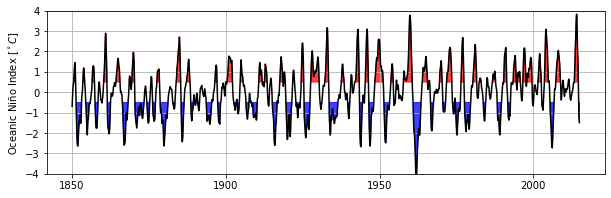

In [9]:
enso1='~/ENSO_SST/ENSO_Project_SST_r1i1001p1f1.nc'
enso1 = xr.open_dataset(enso1)  #xarray can open different format data, netcdf is one of them
print(enso1)                                

sst_1 = enso1['SST'].values; df_sst_1 = enso1.to_dataframe()

weights = np.cos(np.deg2rad(enso1.lat)); weights.name = "weights" # area of the cell scales as dlat*dlon*cos(lat) and we can use it to compute weighted averages; note, dlat=dlon for this dataset.
SST_mean = enso1['SST'].weighted(weights).mean(dim=['lat','lon']) # this IS area-weighted mean
SST_mean_runningMean=SST_mean.rolling(time=12*5,center=True).mean() # global mean smoothed over many months

enso1_clim=enso1.groupby("time.month").mean('time') # calculate anomalies
enso1_a = enso1.groupby("time.month")-enso1_clim

NINO34 = enso1_a['SST'].sel(lat=slice(-5,5), lon=slice(190,240)).mean(dim=['lat','lon'])
ONI= NINO34.rolling(time=3,center=True).mean() #rolling mean over 3 months

plt.figure(figsize=(10,3))
ax=plt.gca()
plt.plot(ONI.time, ONI,'k')
ax.fill_between(ONI.time.data, 0.5, ONI, ONI> 0.5, color='red', alpha=.75)
ax.fill_between(ONI.time.data, -0.5, ONI, ONI< -0.5, color='blue',  alpha=.75)
plt.ylim((-4,4))
plt.grid(visible=True)
plt.ylabel('Oceanic Niño Index [$^\circ C$]');

Text(0.5, 1.0, 'ENSO Method Comparison')

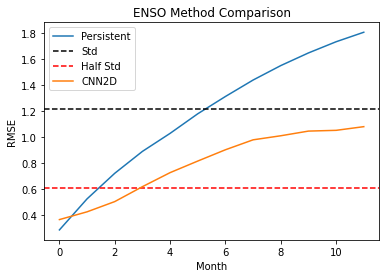

In [16]:
error_persistent = np.zeros((300,12))
for i in range(300):
    i0= random.randint(0,len(NINO34)-13)
    error_persistent[i,:] = (NINO34[i0+1:i0+13] - NINO34[i0].values*np.ones(12))**2
rms_persistence = (np.mean(error_persistent, axis=0))**0.5
plt.plot(rms_persistence,label='Persistent')
plt.axhline(np.std(NINO34), color='k', linestyle='--',label = 'Std' )
plt.axhline(np.std(NINO34)/2, color='r', linestyle='--', label = 'Half Std')
plt.plot(error, label = 'CNN2D')
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.legend()
plt.title('ENSO Method Comparison')

In [18]:
plt.savefig('image1.png')

<Figure size 432x288 with 0 Axes>

In [20]:
np.save('errorCNN2D.npy',error)